# Connect Three 

The primary description of this coursework is available on the CM20252 Moodle page. This is the Jupyter notebook you must complete and submit to receive marks. This notebook adds additional detail to the coursework specification but does not repeat the information that has already been provided there. 

You must follow all instructions given in this notebook precisely.

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing. Remember to save your work regularly.

__You will develop players for Connect-Three on a grid that is 5 columns wide and 3 rows high. An example is shown below showing a win for Player Red.__

<img src="images/connect3.png" style="width: 200px;"/>

## Preliminaries

For your reference, below is a visual depiction of the agent-environment interface in reinforcment learning. The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$. 

<img src="images/agent-environment.png" style="width: 500px;"/>

<br><br><br>

Below, we provide some code that will be useful for implementing parts of this interface. You are not obligated to use this code; please feel free to develop your own code from scratch. 

### Code details

We provide a `Connect` class that you can use to simulate Connect-Three games. The following cells in this section will walk you through the basic usage of this class by playing a couple of games.

We import the `connect` module and create a Connect-Three environmnet called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the `Connect` object will regularly print the progress of the game. This is useful for getting to know the provided code, debugging your code, or if you just want to play around. You will want to set `verbose=False` when you run hundreds of episodes to complete the marked exercises.

This `Connect` environment uses the strings `'o'` and `'x'` instead of different disk colors in order to distuingish between the two players.

Before we start a game, we should call the `reset()` method. This method cleans the board and resets other state variables. The `first_player` argument can be specified (`'o'` or `'x'`) to deterministically choose the starting player. It defaults to `"random"`, in which case each player starts the game with probability of $\frac{1}{2}$.

In [1]:
import connect
env = connect.Connect(verbose=True)
env.reset(first_player='o')

Game has been reset.
[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']]


We can interact with the environment using the `act()` method. This method takes an `action` as input and computes the response of the environment. An action is defined as the column index that a disk is dropped into.

In [2]:
env.act(action=2)

[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']]


The `act()` method inserts a disk into the specified column. 

If we want to change the player on move, we can do so by using the `change_turn()` method. We can check whose turn it is by accessing the `.player_at_turn` attribute.

In [3]:
print("Current player at turn:", env.player_at_turn)
env.change_turn()
print("Current player at turn:", env.player_at_turn)

# Drop another disk into the same centre column.
env.act(action=2)

Current player at turn: o
Current player at turn: x
[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']]


Because we set `verbose=True`, the grid is printed each time we call the `act()` method. This grid is stored as a two-dimensional numpy array in the connect class and you can easily access by calling...

In [4]:
current_grid = env.grid
print(current_grid)
# Notice that the grid now appears to be "upside down" because numpy arrays are printed from "top to bottom".

[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']]


In [5]:
# Let's make another move.
env.change_turn()
env.act(action=2)

[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']]


If we make another move with `act(action=2)`, the environment will throw an error because that column is already filled.

In [6]:
# This cell should throw an error!
env.change_turn()
env.act(action=2)

IndexError: index 3 is out of bounds for axis 0 with size 3

The attribute `.available_actions` contains a numpy array of all not yet filled columns.

In [7]:
print(env.available_actions)
# Column index '2' is missing because this column is already filled

[0 1 3 4]


The `Connect` class contains a method called `was_winning_move()` that checks whether the last move won the game (returns `True`) or not (returns `False`). 

In [8]:
# Obviously the game has not yet been won by any player.
print("Winning move?", env.was_winning_move()) 

# Make some moves
env.act(action=3)
env.change_turn()
env.act(action=1)
env.change_turn()
env.act(action=3)
env.change_turn()
env.act(action=0)

# Check again whether a player has won the game.
print("Winning move?", env.was_winning_move()) 

Winning move? False
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' 'o' 'x' ' ']]
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' 'o' 'o' 'x' ' ']]
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' 'x' ' ']
 [' ' 'o' 'o' 'x' ' ']]
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' 'x' ' ']
 ['o' 'o' 'o' 'x' ' ']]
Player ' o ' has won the game!
Winning move? True


Finally, the `Connect` class contains a method called `grid_is_full()` that checks whether the grid still contains empty slots. You can use this method to check whether the game is a draw.

Feel free to modify existing or add new methods to the `Connect` class.

## Part 1: Q-learning

Your opponent is always the first player. Your agent is always the second player.

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>

Prepare a **learning curve** following the directions below. We refer to this as Plot 1.

After $n$ steps of interaction with the environment, play $m$ games with the current policy of the agent (without modifying the policy). Think of this as interrupting the agent for a period of time to test how well it has learned so far. Your plot should show the total score obtained in these $m$ games as a function of $n, 2n, 3n, … kn$. The choices of $n$ and $k$ are up to you. They should be reasonable values that demonstrate the efficiency of the learning and how well the agent learns to play the game eventually. Use $m=10$. 

This plot should show the mean performance of $a$ agents, not the performance of a single agent. Because of the stochasticity in the environment, you will obtain two different learning curves from two different agents even though they are using exactly the same algorithm. We suggest setting $a$ to 30 or higher.

Present a single mean learning curve with your choice of parameters $\epsilon$ and $\alpha$. The plot should also show (as a baseline) the mean performance of a random agent that does not learn but chooses actions uniformly randomly from among the legal actions. Label this line “Random Agent”. 

Please include this plot as a static figure in the appropriate cell below. You can look at the source code of this markdown cell to find out how to embed figures using html or you can use drag & drop. If you link to locally stored images, make sure to include those in your submission.

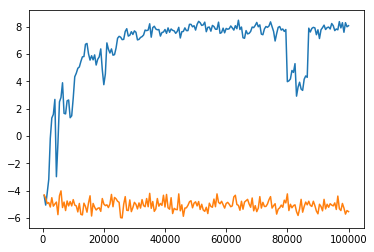

In [14]:
### Write all your code for Part 1 within or above this cell. 
import numpy as np
import random
import connect
import math
import matplotlib.pyplot as plt


env = connect.Connect(verbose=False)
Q = {}
epsilon = 0.2
alpha = 0.5
games_won = []
random_games_won = []
k_played = []


# Sets up the game setting the first player to 'o' and playing in the middle column. 
# State-action pairs are added to the Q table.
def setup_game():
    global k_played
    global games_won
    global random_games_won
    global Q
    Q = {}
    k_played = []
    games_won = []
    random_games_won = []
    env.reset(first_player='o')
    env.act(action = 2)
    start_grid = np.array_str(env.grid)
    for i in range(0, 5):
        Q[(start_grid, i)] = 0
    
    
# Returns a random move from the actions available at that state
def make_random_move(state):
    possible_moves = env.available_actions
    return random.choice(possible_moves)


# Returns the best action according to the Q table. Sometimes returns a random choice
# according to the value of epsilon so as to explore the game. 
def get_best_action(state, possible_moves):
    best = -math.inf
    action = -1
    l = len(possible_moves)
    if(random.random() < (epsilon * (1/len(Q)))):
        return random.choice(possible_moves)
    choices = []
    for i in range(0, l):
        move = possible_moves[i]
        qval = Q[(state, move)]
        if(qval > best):
            choices = []
            choices.append(move)
            best = qval
        elif(qval == best):
            choices.append(move)
    return random.choice(choices)


# Adds new state-action pairs to the Q table
def add_states_to_q():
    s = np.array_str(env.grid)
    poss_moves = env.available_actions
    l = len(poss_moves)
    for i in range(0, l):
        if(not ((s, poss_moves[i]) in Q)):
            Q[(s, poss_moves[i])] = 0

            
# Updates Q values according to formula after action has been taken
def update_q_table(s, a):
    Q[(s,a)] = Q[(s,a)] + alpha * (get_max_reward() - Q[(s,a)])
    

# Returns the best reward expected from the current game state.
def get_max_reward():
    s = np.array_str(env.grid)
    poss_moves = env.available_actions
    l = len(poss_moves)
    best = -math.inf
    for i in range(0,l):
        if(Q[(s, poss_moves[i])] > best):
            best = Q[(s, poss_moves[i])]
    return best

    
# Completes 'n' interactions with the game, then plays 'm' games with 'a' agents and repeats 'k' times
def play_game(n, m, k, a):
    amount = 0
    while(amount < k):
        count = 0
        while(count < n):
            play_move()
            count+=1
            
        agents = 0
        graph_array = np.zeros(a)
        random_graph_array = np.zeros(a)
        while(agents < a):
            num = 0
            total = 0
            random_total = 0
            while(num < m):
                total += play_full_game()
                random_total += play_random_game()
                num+=1
            graph_array[agents] = total
            random_graph_array[agents] = random_total
            agents+=1
        games_won.append(np.average(graph_array))
        random_games_won.append(np.average(random_graph_array))
        k_played.append((amount+1)*n)
        amount += 1
        

# Plays a game where both agents choose actions randomly. Stops when win, draw or loss occurs.
def play_random_game():
    env.reset(first_player='o')
    env.act(action = 2)
    while(True):
        env.change_turn()
        env.act(action = make_random_move(env.grid))
        if(env.was_winning_move()):
            env.reset(first_player='o')
            env.act(action = 2)
            return 1
        env.change_turn()
        env.act(action = make_random_move(env.grid))
        if(env.was_winning_move()):
            env.reset(first_player='o')
            env.act(action = 2)
            return -1
        elif(len(env.available_actions) == 0):
            env.reset(first_player='o')
            env.act(action = 2)
            return 0
    

# Plays a game where one agent chooses actions according to the Q table, the other chooses
# actions randomly. Stops when win, draw or loss occurs.
def play_full_game():
    env.reset(first_player='o')
    env.act(action = 2)
    while(True):
        env.change_turn()
        s = np.array_str(env.grid)
        a = env.available_actions
        if((s,a[0]) in Q):
            env.act(action = get_best_action(s, a))
        else:
            env.act(action = make_random_move(env.grid))
        if(env.was_winning_move()):
            env.reset(first_player='o')
            env.act(action = 2)
            return 1
        env.change_turn()
        env.act(action = make_random_move(env.grid))
        if(env.was_winning_move()):
            env.reset(first_player='o')
            env.act(action = 2)
            return -1
        elif(len(env.available_actions) == 0):
            env.reset(first_player='o')
            env.act(action = 2)
            return 0
    

# Performs one turn within a game where one player chooses according to the Q table
# and the other chooses randomly.
def play_move():
    env.change_turn()
    s = np.array_str(env.grid)
    poss_moves = env.available_actions
    a = get_best_action(s, poss_moves)
    env.act(action = a)
    if(env.was_winning_move()):
        Q[(s,a)] = 1
        env.reset(first_player='o')
        env.act(action=2)
    else:
        env.change_turn()
        aprime = make_random_move(env.grid)
        env.act(action = aprime)
        if(env.was_winning_move()):
            Q[(s,a)] = -1
            env.reset(first_player='o')
            env.act(action = 2)
        elif(len(env.available_actions) == 0):
            Q[(s,a)] = 0
            env.reset(first_player='o')
            env.act(action = 2)
        else:
            add_states_to_q()
            update_q_table(s,a)

setup_game()
play_game(500, 10, 200, 50)
plt.plot(k_played, games_won)
plt.plot(k_played, random_games_won)
plt.show()

(A) [continued} Insert your static learning curve here (Plot 1).

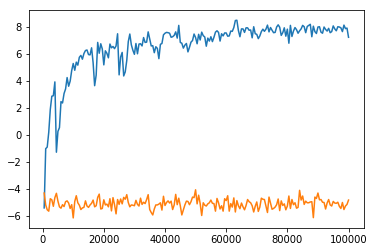 

(B) In 3 sentences or less, explain your conclusions from the plot above. How close does your (average) agent get to the best possible level of performance? How efficiently does your (average) agent learn? 

After around 20000 interactions with the game, the agent obtains an average score of 7 making it very close to the optimal solution. The only way to guarantee a win is by playing in column 2 however the oponent starts here making it impossible to reach the optimal solution. To reach a near optimal solution takes around 20000 interactions with the game which can be computed in less than a minute making it an efficient algorithm. 

(C) In five sentences or less, explain the key aspects of your implementation. How many state-action pairs do you represent in your Q-table? Describe and justify your settings of $\alpha$ and $\epsilon$. Are there any things you tried out that are not in your final implementation?

My implementation perfomrs 500 interactions with the game to learn the game, then playes 10 games with 50 agents using the values in the Q table or chooses randomly if the state action pair is not in the Q table. This is repeated 200 times to show the learning curve of the agent. The Q table contains around 10000 state-action pairs but this depends on the choices made by the random player. Alpha is static and Epsilon decreases over time as it is inversely proportional to the size of my Q table meaning that the more the agent knows about the game the more it exploits and the less it explores.

(D) In the cell below, make it possible for us to produce from scratch a learning curve similar to Plot 1 but for a single agent, for a $k$ value of your own choosing. You do not need to include the baseline for random play.  This code should run in less than 30 seconds (ours runs in 2 seconds). 


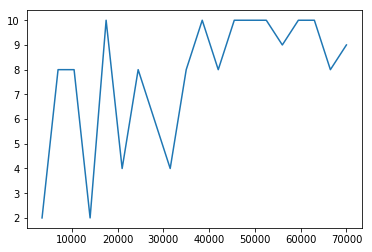

In [15]:
# Completes 'n' interactions with the game, then plays 'm' games and repeats 'k' times
def play_game(n, m, k):
    amount = 0
    while(amount < k):
        count = 0
        while(count < n):
            play_move()
            count+=1
        num = 0
        total = 0
        while(num < m):
            total += play_full_game()
            num+=1
        games_won.append(total)
        k_played.append((amount+1)*n)
        amount += 1
        

setup_game()
play_game(3500, 10, 20)
plt.plot(k_played, games_won)
plt.show()


## Part 2A
 
Using the minimax policy you computed, answer the following question: The first player (Player 1) drops his/her first disk into column 2 (counting from the left). Consider the resulting state, shown in the following code cell. 

In [35]:
env = connect.Connect(verbose=False)
env.reset(first_player='o')
env.act(action=1)
print(env.grid[::-1])

[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' 'o' ' ' ' ' ' ']]


What is the Minimax Value of this state for Player 2? That is, assuming an optimal opponent, does the Minimax Policy expect to win the game (value = 1), lose the game (value = –1), or end the game in a draw (value = 0)? Please state your answer as a number.    

* The code cell below should compute this value and assign it to a variable called `state_value`.
* Count the number of branches of the game tree that were examined and assign this number to a variable called `num_branches`.

In [16]:
### Write all your code for Part 2A in or above this cell.
import numpy as np
import connect
import math

count = 0
actions = []


# Minimax algorithm using alpha beta pruning to reduce the number of 
# branches considered
def minimax(state, alpha, beta, max_player):
    moves = []
    global count
    global actions
    count += 1
    win = state.was_winning_move()
    # Terminal state checks
    if(win and max_player):
        return -1
    elif(win and not max_player):
        return 1
    elif(len(state.available_actions) == 0):
        return 0
    
    # Performs max if maximising player's ture
    if(max_player):
        q = -math.inf
        possible_actions = state.available_actions
        l = len(possible_actions)
        for i in range(0, l):
            child = connect.Connect(verbose = False)
            child.reset(first_player='o')
            child.change_turn()
            child.grid = state.grid.copy()
            child.available_actions = state.available_actions.copy()
            child.lowest_free_rows = state.lowest_free_rows.copy()
            child.act(action = possible_actions[i])
            p = minimax(child, alpha, beta, False)
            if(p > q):
                moves = []
                moves.append(possible_actions[i])
            elif(p == q):
                moves.append(possible_actions[i])
            q = max(q, p)
            alpha = max(alpha, q)
            if(beta <= alpha):
                break

    # Performs min if minimising player's ture
    else:
        q = math.inf
        possible_actions = state.available_actions
        l = len(possible_actions)
        for i in range(0, l):
            child = connect.Connect(verbose = False)
            child.reset(first_player='o')
            child.grid = state.grid.copy()
            child.available_actions = state.available_actions.copy()
            child.lowest_free_rows = state.lowest_free_rows.copy()
            child.act(action = possible_actions[i])
            q = min(q, minimax(child, alpha, beta, True))
            beta = min(beta, q)
            if(beta <= alpha):
                break
    actions = moves
    return q
        
env = connect.Connect(verbose = False)
env.reset(first_player='o')
env.act(action = 1)
state_value = minimax(env, -math.inf, math.inf, True)
num_branches = count


In [ ]:
# This is an autograded test cell. Do not delete or change, otherwise you will get 
# no marks for this part of the assignment. Please make sure that this cell has 
# access to the variables state_value and num_branches.

## Part 2B
Plot a learning curve similar to the one in Part 1, comparing your Q-learning algorithm, random play, and Minimax play. Assume as before that the opponent always plays first and uses a random policy.

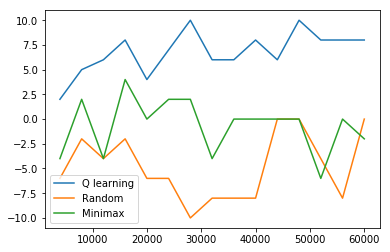

In [17]:
import numpy as np
import random
import connect
import math
import matplotlib.pyplot as plt 

minimax_games_won = []

# Performs n interactions then plays m games with a agens k times.
# Plays with q learning agent, random agent and minimax agent.
def play_game(n, m, k, a):
    amount = 0
    while(amount < k):
        count = 0
        while(count < n):
            play_move()
            count+=1
            
        agents = 0
        graph_array = np.zeros(a)
        random_graph_array = np.zeros(a)
        minimax_gaph_array = np.zeros(a)
        while(agents < a):
            num = 0
            total = 0
            random_total = 0
            minimax_total = 0
            while(num < m):
                total += play_full_game()
                random_total += play_random_game()
                minimax_total += play_minimax_game()
                num+=1
            graph_array[agents] = total
            random_graph_array[agents] = random_total
            minimax_graph_array = minimax_total
            agents+=1
        games_won.append(np.average(graph_array))
        random_games_won.append(np.average(random_graph_array))
        minimax_games_won.append(np.average(minimax_graph_array))
        k_played.append((amount+1)*n)
        amount += 1
        

# plays a game using the minimax algorithm.
def play_minimax_game():
    env.reset(first_player='o')
    env.act(action = 2)
    while(True):
        env.change_turn()
        minimax(env, -math.inf, math.inf, True)
        env.act(action = random.choice(actions))
        if(env.was_winning_move()):
            env.reset(first_player='o')
            env.act(action = 2)
            return 1
        env.change_turn()
        env.act(action = make_random_move(env.grid))
        if(env.was_winning_move()):
            env.reset(first_player='o')
            env.act(action = 2)
            return -1
        elif(len(env.available_actions) == 0):
            env.reset(first_player='o')
            env.act(action = 2)
            return 0

        
setup_game()
play_game(4000, 10, 15, 1)
plt.plot(k_played, games_won, label='Q learning')
plt.plot(k_played, random_games_won, label='Random')
plt.plot(k_played, minimax_games_won, label='Minimax')
plt.legend()
plt.show()

Explain your findings in 3 or fewer sentences. Which policy is better? Why?

Random loses the most, then minimax and q learning wins the most. Q learning agent is trained against a random player and so chooses its moves knowing this, the minimax algorithm presumes an optimal oponent and so loses lots of games. Below is a more accurate graph calculated using more agents.

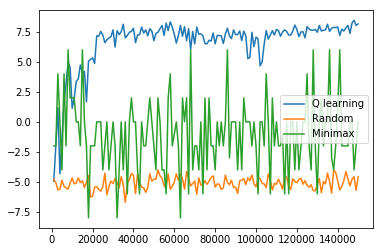



## Part 3

Using your algorithm, compute the value of the game for your player (recall: your player goes second against a random opponent). The code cell below should compute this value and assign it to a variable called `optimal_policy_value`.

In [18]:
### Write all your code for Part 3 in or above this cell.
import numpy as np
import connect
import math


# Minimax algorithm used against random opponent.
# Calculates expected value rather than min.
def minimax_random(state, max_player):
    win = state.was_winning_move()
    if(win and max_player):
        return -1
    elif(win and not max_player):
        return 1
    elif(len(state.available_actions) == 0):
        return 0
    if(max_player):
        q = -math.inf
        possible_actions = state.available_actions
        l = len(possible_actions)
        for i in range(0, l):
            child = connect.Connect(verbose = False)
            child.reset(first_player='o')
            child.change_turn()
            child.grid = state.grid.copy()
            child.available_actions = state.available_actions.copy()
            child.lowest_free_rows = state.lowest_free_rows.copy()
            child.act(action = possible_actions[i])
            p = minimax_random(child, False)
            q = max(q, p)
        return q
    else:
        q = math.inf
        p = 0
        possible_actions = state.available_actions
        l = len(possible_actions)
        for i in range(0, l):
            child = connect.Connect(verbose = False)
            child.reset(first_player='o')
            child.change_turn()
            child.grid = state.grid.copy()
            child.available_actions = state.available_actions.copy()
            child.lowest_free_rows = state.lowest_free_rows.copy()
            child.act(action = possible_actions[i])
            p += minimax_random(child, True)
        return p/l
        

env = connect.Connect(verbose = False)
env.reset(first_player='o')
env.act(action = 4)
optimal_policy_value = minimax_random(env, True)


I used the expected value to calculate the probability of winning for the maximising player. This was done by summing up all the possible state values the random player expected to get at a particular state and dividing by the number of actions. This then returned the expected win, draw or loss rate over a large number of games.

In [ ]:
# This is an autograded test cell. Do not delete or change, otherwise you will get 
# no marks for this part of the assignment. Please make sure that this cell has 
# access to the variable optimal_policy_value.